In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def linearTriangulation(p1, p2, M1, M2):
    """ Linear Triangulation
     Input:
      - p1 np.ndarray(3, N): homogeneous coordinates of points in image 1
      - p2 np.ndarray(3, N): homogeneous coordinates of points in image 2
      - M1 np.ndarray(3, 4): projection matrix corresponding to first image
      - M2 np.ndarray(3, 4): projection matrix corresponding to second image

     Output:
      - P np.ndarray(4, N): homogeneous coordinates of 3-D points
    """
    p_size = p1.shape[1]
    P_est = np.ones([p_size,4])
    for i in range (p_size):
        temp_p1_x = cross2Matrix(p1[:,i].squeeze())
        temp_p2_x = cross2Matrix(p2[:,i].squeeze())
        temp_A = np.r_[temp_p1_x@M1, temp_p2_x@M2]
        _,_, VT = np.linalg.svd(temp_A,full_matrices=True)
        P_est[i,]  = VT.T[:,-1] / VT.T[3,-1]   

    
    return P_est.T


In [3]:
def normalise2DPts(pts):
    """  normalises 2D homogeneous points

     Function translates and normalises a set of 2D homogeneous points
     so that their centroid is at the origin and their mean distance from
     the origin is sqrt(2).

     Usage:   [pts_tilde, T] = normalise2dpts(pts)

     Argument:
       pts -  3xN array of 2D homogeneous coordinates

     Returns:
       pts_tilde -  3xN array of transformed 2D homogeneous coordinates.
       T         -  The 3x3 transformation matrix, pts_tilde = T*pts
    """
    
    pts_E = pts/pts[2:,]
    miu = np.mean(pts_E[:2,:], axis = 1)
    
    pts_dis = pts_E[:2,:].T - miu
    sigma = np.sqrt(np.mean(np.sum(pts_dis**2, axis = 1)))
    s = np.sqrt(2) / sigma
    T = np.array([
    [s, 0, -s * miu[0]],
    [0, s, -s * miu[1]],
    [0, 0, 1]])
    pts_tilde = T @ pts_E
    return pts_tilde, T

In [4]:
def fundamentalEightPoint(p1, p2):
    """ The 8-point algorithm for the estimation of the fundamental matrix F

     The eight-point algorithm for the fundamental matrix with a posteriori
     enforcement of the singularity constraint (det(F)=0).
     Does not include data normalization.

     Reference: "Multiple View Geometry" (Hartley & Zisserman 2000), Sect. 10.1 page 262.

     Input: point correspondences
      - p1 np.ndarray(3,N): homogeneous coordinates of 2-D points in image 1
      - p2 np.ndarray(3,N): homogeneous coordinates of 2-D points in image 2

     Output:
      - F np.ndarray(3,3) : fundamental matrix
    """

    num_P = p1.shape[1]
    A = np.zeros((num_P, 9))
    for i in range(num_P):
        A[i, :] = np.kron(p1[:, i], p2[:, i]).T
    U, sigma, VT = np.linalg.svd(A, full_matrices=True)
    F = VT.T[:, -1].reshape(3, 3)
    U_F, sigma_F, VT_F = np.linalg.svd(F, full_matrices=True)
    sigma_F[2] = 0
    F_mod = U_F @ np.diag(sigma_F) @ VT_F
    
    return F_mod

In [5]:
def fundamentalEightPointNormalized(p1, p2):
    """ Normalized Version of the 8 Point algorith
     Input: point correspondences
      - p1 np.ndarray(3,N): homogeneous coordinates of 2-D points in image 1
      - p2 np.ndarray(3,N): homogeneous coordinates of 2-D points in image 2

     Output:
      - F np.ndarray(3,3) : fundamental matrix
    """
    p1_n, T1 = normalise2DPts(p1)
    p2_n, T2 = normalise2DPts(p2)
    
    F_ = fundamentalEightPoint(p1_n, p2_n)
    
    F = T2.T @ F_ @T1
    
    return F

In [6]:
def cross2Matrix(x):
    """ Antisymmetric matrix corresponding to a 3-vector
     Computes the antisymmetric matrix M corresponding to a 3-vector x such
     that M*y = cross(x,y) for all 3-vectors y.

     Input: 
       - x np.ndarray(3,1) : vector

     Output: 
       - M np.ndarray(3,3) : antisymmetric matrix
    """
    M = np.array([[0,   -x[2], x[1]], 
                  [x[2],  0,  -x[0]],
                  [-x[1], x[0],  0]])
    return M

In [7]:
import numpy as np

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)


In [8]:


def drawCamera(ax, position, direction, length_scale = 1, head_size = 10, 
        equal_axis = True, set_ax_limits = True):
    # Draws a camera consisting of arrows into a 3d Plot
    # ax            axes object, creates as follows
    #                   fig = plt.figure()
    #                   ax = fig.add_subplot(projection='3d')
    # position      np.array(3,) containing the camera position
    # direction     np.array(3,3) where each column corresponds to the [x, y, z]
    #               axis direction
    # length_scale  length scale: the arrows are drawn with length
    #               length_scale * direction
    # head_size     controls the size of the head of the arrows
    # equal_axis    boolean, if set to True (default) the axis are set to an 
    #               equal aspect ratio
    # set_ax_limits if set to false, the plot box is not touched by the function

    arrow_prop_dict = dict(mutation_scale=head_size, arrowstyle='-|>', color='r')
    a = Arrow3D([position[0], position[0] + length_scale * direction[0, 0]],
                [position[1], position[1] + length_scale * direction[1, 0]],
                [position[2], position[2] + length_scale * direction[2, 0]],
                **arrow_prop_dict)
    ax.add_artist(a)
    arrow_prop_dict = dict(mutation_scale=head_size, arrowstyle='-|>', color='g')
    a = Arrow3D([position[0], position[0] + length_scale * direction[0, 1]],
                [position[1], position[1] + length_scale * direction[1, 1]],
                [position[2], position[2] + length_scale * direction[2, 1]],
                **arrow_prop_dict)
    ax.add_artist(a)
    arrow_prop_dict = dict(mutation_scale=head_size, arrowstyle='-|>', color='b')
    a = Arrow3D([position[0], position[0] + length_scale * direction[0, 2]],
                [position[1], position[1] + length_scale * direction[1, 2]],
                [position[2], position[2] + length_scale * direction[2, 2]],
                **arrow_prop_dict)
    ax.add_artist(a)

    if not set_ax_limits:
        return

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    ax.set_xlim([min(xlim[0], position[0]), max(xlim[1], position[0])])
    ax.set_ylim([min(ylim[0], position[1]), max(ylim[1], position[1])])
    ax.set_zlim([min(zlim[0], position[2]), max(zlim[1], position[2])])
    
    # This sets the aspect ratio to 'equal'
    if equal_axis:
        ax.set_box_aspect((np.ptp(ax.get_xlim()),
                       np.ptp(ax.get_ylim()),
                       np.ptp(ax.get_zlim())))

## 数据读入 与函数

In [9]:
import os
dirname = os.path.dirname('/home/mullin/WorkSpace/CourseProject/3 VAMR/Exercise 6/python/')

In [10]:
img_1 = np.array(cv2.imread(dirname+'/data/0001.jpg'))
img_2 = np.array(cv2.imread(dirname+'/data/0002.jpg'))

In [11]:
K = np.array([  [1379.74,   0,          760.35],
                [    0,     1382.08,    503.41],
                [    0,     0,          1 ]] )

In [12]:
# Load outlier-free point correspondences
p1 = np.loadtxt(dirname+'/data/matches0001.txt')
p2 = np.loadtxt(dirname+'/data/matches0002.txt')

p1 = np.r_[p1, np.ones((1, p1.shape[1]))]
p2 = np.r_[p2, np.ones((1, p2.shape[1]))]

## Test 

## estimate Essential Matrix 

In [27]:
def estimateEssentialMatrix(p1, p2, K1, K2):
    """ estimates the essential matrix given matching point coordinates,
        and the camera calibration K

     Input: point correspondences
      - p1 np.ndarray(3,N): homogeneous coordinates of 2-D points in image 1
      - p2 np.ndarray(3,N): homogeneous coordinates of 2-D points in image 2
      - K1 np.ndarray(3,3): calibration matrix of camera 1
      - K2 np.ndarray(3,3): calibration matrix of camera 2

     Output:
      - E np.ndarray(3,3) : fundamental matrix
    """
    
    F = fundamentalEightPointNormalized(p1,p2)
    print("F:\n", F)
    E = K2.T @ F @ K1
    
    return E


## Function：DecomposeEMatrix

In [14]:
def decomposeEssentialMatrix(E):
    """ Given an essential matrix, compute the camera motion, i.e.,  R and T such
     that E ~ T_x R
     
     Input:
       - E(3,3) : Essential matrix

     Output:
       - R(3,3,2) : the two possible rotations
       - u3(3,1)   : a vector with the translation information
    """
    
    W = np.array([[0, -1, 0],
                  [1,  0,  0],
                  [0,  0,  1 ]] )
    
    U, sigma, VT = np.linalg.svd(E, full_matrices=True)
    R = np.zeros([3,3,2])
    if (np.linalg.det(U @ W @ VT) > 0):   
        R[:,:,0] = U @ W @ VT
    else:
        R[:,:,0] = - U @ W @ VT
    
    if (np.linalg.det(U @ W.T @ VT) > 0):
        R[:,:,1] = U @ W.T @ VT
    else:
        R[:,:,1] = - U @ W.T @ VT
    
    u3 = U[:,2]
    
    if np.linalg.norm(u3) != 0:
        u3 /= np.linalg.norm(u3)
    
    return R, u3

### test for decompose

In [15]:
    W = np.array([[0, -1, 0],
                  [1,  0,  0],
                  [0,  0,  1 ]] )

In [16]:
U, sigma, VT = np.linalg.svd(E, full_matrices=True)

NameError: name 'E' is not defined

In [17]:
U[:,2]

NameError: name 'U' is not defined

In [18]:
U @ W @ VT

array([[-9.66560148e-01,  2.50368550e-04,  2.56439890e-01],
       [ 3.56035084e-04,  9.99999870e-01,  3.65624889e-04],
       [ 2.56439765e-01, -4.44700045e-04,  9.66560112e-01]])

In [19]:
U @ W.T @ VT

array([[-9.81051429e-01, -4.43919147e-03, -1.93696639e-01],
       [ 4.62877772e-03, -9.99989149e-01, -5.26213051e-04],
       [ 1.93692201e-01,  1.41282075e-03, -9.81061331e-01]])

In [20]:
R = np.zeros([3,3,2])

In [23]:
if (np.linalg.det(U @ W @ VT) > 0):
    
    R[:,:,0] = U @ W @ VT
else:
    R[:,:,0] = - U @ W @ VT
    
if (np.linalg.det(U @ W.T @ VT) > 0):
    
    R[:,:,1] = U @ W.T @ VT
else:
    R[:,:,1] = - U @ W.T @ VT

In [25]:
R.shape

(3, 3, 2)

In [28]:
np.linalg.det(U @ W @ VT)

-0.9999999999999999

In [29]:
np.linalg.det(U @ W.T @ VT)

-0.9999999999999999

## Funtion：disambiguate

In [59]:
def disambiguateRelativePose(Rots,u3,points0_h,points1_h,K1,K2):
    """ DISAMBIGUATERELATIVEPOSE- finds the correct relative camera pose (among
     four possible configurations) by returning the one that yields points
     lying in front of the image plane (with positive depth).

     Arguments:
       Rots -  3x3x2: the two possible rotations returned by decomposeEssentialMatrix
       u3   -  a 3x1 vector with the translation information returned by decomposeEssentialMatrix
       p1   -  3xN homogeneous coordinates of point correspondences in image 1
       p2   -  3xN homogeneous coordinates of point correspondences in image 2
       K1   -  3x3 calibration matrix for camera 1
       K2   -  3x3 calibration matrix for camera 2

     Returns:
       R -  3x3 the correct rotation matrix
       T -  3x1 the correct translation vector

       where [R|t] = T_C2_C1 = T_C2_W is a transformation that maps points
       from the world coordinate system (identical to the coordinate system of camera 1)
       to camera 2.
    """
    M1 = K1 @ np.c_[np.eye(3), np.zeros((3,1))]
    M2 = np.zeros((3,4,4))
    M2[:,:,0] = K2 @ np.c_[Rots[:,:,0], u3]
    M2[:,:,1] = K2 @ np.c_[Rots[:,:,1], u3]
    M2[:,:,2] = K2 @ np.c_[Rots[:,:,0], -u3]
    M2[:,:,3] = K2 @ np.c_[Rots[:,:,1], -u3]
    num_point_posdepth = np.zeros(4)
    for i in range (4):
        P_c1 = linearTriangulation(points0_h, points1_h, M1, M2[:,:,i])
        P_c2 = np.linalg.inv(K2) @ M2[:,:,i] @ P_c1
        num_point_posdepth[i] = np.sum(P_c1[2,:] > 0) + np.sum(P_c2[2,:] > 0)
        
    M_T = np.linalg.inv(K2) @ M2[:,:,np.argmax(num_point_posdepth)]
    return M_T[:,0:3],M_T[:,3]

### Test for disambiguate 

In [44]:
M1 = np.c_[np.eye(3), np.zeros((3,1))]

In [45]:
M1

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [46]:
M1.shape

(3, 4)

In [47]:
M2 = np.zeros((3,4,4))

In [48]:
K2 =K
M2[:,:,0] = K2 @ np.c_[Rots[:,:,0], u3]
M2[:,:,1] = K2 @ np.c_[Rots[:,:,1], u3]
M2[:,:,2] = K2 @ np.c_[Rots[:,:,0], -u3]
M2[:,:,3] = K2 @ np.c_[Rots[:,:,1], -u3]

In [49]:
num_point_posdepth = np.zeros(4)
points0_h = p1
points1_h = p2
for i in range (4):
    P_c1 = linearTriangulation(points0_h, points1_h, M1, M2[:,:,i])
    P_c2 = np.linalg.inv(K2) @ M2[:,:,i] @ P_c1
    num_point_posdepth[i] = np.sum(P_c1[2,:] > 0) + np.sum(P_c2[2,:] > 0)


In [50]:
num_point_posdepth

array([ 78., 113.,  90.,  55.])

In [51]:
M2[:,0:3,np.argmax(num_point_posdepth)]

array([[ 1.20632203e+03,  5.05069178e+00,  1.01320098e+03],
       [-1.03903932e+02,  1.38135377e+03,  4.94603353e+02],
       [-1.93692201e-01, -1.41282075e-03,  9.81061331e-01]])

In [56]:
index

1

In [52]:
np.linalg.inv(K2) @ M2[:,:,i]

array([[ 9.81051429e-01,  4.43919147e-03,  1.93696639e-01,
         9.74313235e-01],
       [-4.62877772e-03,  9.99989149e-01,  5.26213051e-04,
        -2.49370519e-03],
       [-1.93692201e-01, -1.41282075e-03,  9.81061331e-01,
        -2.25183264e-01]])

## CODE

In [28]:
# Estimate the essential matrix E using the 8-point algorithm
E = estimateEssentialMatrix(p1, p2, K, K);
print("E:\n", E)

F:
 [[-9.57519791e-10  3.76386464e-07 -1.95028779e-04]
 [-5.24686714e-08  3.96320048e-09 -2.20888791e-03]
 [ 2.22281522e-05  1.95871052e-03  1.29791403e-01]]
E:
 [[-1.82281364e-03  7.17735511e-01 -8.66493166e-03]
 [-1.00053090e-01  7.57028808e-03 -3.10523987e+00]
 [-6.77887209e-03  3.10538322e+00 -3.10327163e-03]]


In [60]:
# Extract the relative camera positions (R,T) from the essential matrix
# Obtain extrinsic parameters (R,t) from E
Rots, u3 = decomposeEssentialMatrix(E)

In [55]:
Rots

array([[[ 9.66560148e-01,  9.81051429e-01],
        [-2.50368550e-04,  4.43919147e-03],
        [-2.56439890e-01,  1.93696639e-01]],

       [[-3.56035084e-04, -4.62877772e-03],
        [-9.99999870e-01,  9.99989149e-01],
        [-3.65624889e-04,  5.26213051e-04]],

       [[-2.56439765e-01, -1.93692201e-01],
        [ 4.44700045e-04, -1.41282075e-03],
        [-9.66560112e-01,  9.81061331e-01]]])

In [30]:
u3

array([-0.97431323,  0.00249371,  0.22518326])

In [61]:
# Disambiguate among the four possible configurations
R_C2_W,T_C2_W = disambiguateRelativePose(Rots, u3, p1, p2, K, K)

In [62]:
R_C2_W

array([[ 9.81051429e-01,  4.43919147e-03,  1.93696639e-01],
       [-4.62877772e-03,  9.99989149e-01,  5.26213051e-04],
       [-1.93692201e-01, -1.41282075e-03,  9.81061331e-01]])

In [63]:
R_C2_W_sol

array([[ 9.81051429e-01,  4.43919147e-03,  1.93696639e-01],
       [-4.62877772e-03,  9.99989149e-01,  5.26213051e-04],
       [-1.93692201e-01, -1.41282075e-03,  9.81061331e-01]])

In [64]:
T_C2_W

array([-0.97431323,  0.00249371,  0.22518326])

In [65]:
T_C2_W_sol

array([-0.97431323,  0.00249371,  0.22518326])

In [73]:
# Triangulate a point cloud using the final transformation (R,T)
M1 = K @ np.eye(3,4)
M2 = K @ np.c_[R_C2_W, T_C2_W]
P = linearTriangulation(p1, p2, M1, M2)

In [74]:
P

array([[ 2.31335417e+00,  3.01024227e+00,  2.05837557e+00,
         9.42021489e-01,  1.03659728e+00,  9.21270745e+00,
        -1.21598145e+01,  9.25221514e-01,  1.05145270e+00,
        -1.72336648e-02,  1.07854026e+00,  5.90502855e-01,
         8.99612240e-01,  1.06169985e+00,  8.62361399e-01,
        -1.80283490e+00, -2.18187564e-01,  1.28047886e+00,
         8.85880703e-01, -1.69554571e+00,  1.03832868e+00,
         1.40563857e+00, -2.99293070e-03,  9.79755903e-01,
        -1.26106944e+00, -1.55727836e+00, -1.45394813e+00,
        -1.43776132e+00,  1.56508922e+00,  6.20417593e-01,
        -1.31269189e+00, -1.42634350e+00,  7.21252046e-02,
         1.69985967e+00, -6.36123503e-02, -6.83903669e-01,
         4.24453479e-01,  1.66284698e+00,  1.68818340e+00,
         1.44578426e+00,  1.72242253e+00, -3.63128762e-01,
        -1.33800772e+00, -1.27489663e+00, -1.23979481e+00,
        -1.22588780e+00, -1.19696098e+00, -1.19814961e+00,
        -1.46469143e-01,  1.51542932e+00,  1.72088725e+0

/tmp/ipykernel_6603/2007158205.py:13: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


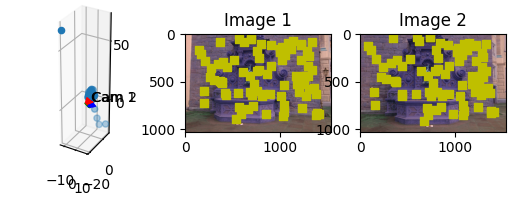

In [76]:
#Visualize the 3-D scene
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1, projection='3d')

# R,T should encode the pose of camera 2, such that M1 = [I|0] and M2=[R|t]

# P is a [4xN] matrix containing the triangulated point cloud (in
# homogeneous coordinates), given by the function linearTriangulation
ax.scatter(P[0,:], P[1,:], P[2,:], marker = 'o')

# Display camera pose
drawCamera(ax, np.zeros((3,)), np.eye(3), length_scale = 2)
ax.text(-0.1,-0.1,-0.1,"Cam 1")

center_cam2_W = -R_C2_W.T @ T_C2_W
drawCamera(ax, center_cam2_W, R_C2_W.T, length_scale = 2)
ax.text(center_cam2_W[0]-0.1, center_cam2_W[1]-0.1, center_cam2_W[2]-0.1,'Cam 2')

# Display matched points
ax = fig.add_subplot(1,3,2)
ax.imshow(img_1)
ax.scatter(p1[0,:], p1[1,:], color = 'y', marker='s')
ax.set_title("Image 1")

ax = fig.add_subplot(1,3,3)
ax.imshow(img_2)
ax.scatter(p2[0,:], p2[1,:], color = 'y', marker='s')
ax.set_title("Image 2")

plt.show()

 [[-1.82281364e-03  7.17735511e-01 -8.66493166e-03]
 [-1.00053090e-01  7.57028808e-03 -3.10523987e+00]
 [-6.77887209e-03  3.10538322e+00 -3.10327163e-03]]

##  Solution

In [24]:
def estimateEssentialMatrix_solution(p1, p2, K1, K2):
    """ estimates the essential matrix given matching point coordinates,
        and the camera calibration K

     Input: point correspondences
      - p1 np.ndarray(3,N): homogeneous coordinates of 2-D points in image 1
      - p2 np.ndarray(3,N): homogeneous coordinates of 2-D points in image 2
      - K1 np.ndarray(3,3): calibration matrix of camera 1
      - K2 np.ndarray(3,3): calibration matrix of camera 2

     Output:
      - E np.ndarray(3,3) : fundamental matrix
    """

    F = fundamentalEightPointNormalized(p1, p2);
    print("F:\n", F)

    # Compute the essential matrix from the fundamental matrix given K
    E = K2.T @ F @ K1

    return E

In [25]:
# Estimate the essential matrix E using the 8-point algorithm
E = estimateEssentialMatrix_solution(p1, p2, K, K);
print("E:\n", E)

F:
 [[-9.57519791e-10  3.76386464e-07 -1.95028779e-04]
 [-5.24686714e-08  3.96320048e-09 -2.20888791e-03]
 [ 2.22281522e-05  1.95871052e-03  1.29791403e-01]]
E:
 [[-1.82281364e-03  7.17735511e-01 -8.66493166e-03]
 [-1.00053090e-01  7.57028808e-03 -3.10523987e+00]
 [-6.77887209e-03  3.10538322e+00 -3.10327163e-03]]


In [31]:
def decomposeEssentialMatrix_sol(E):
    """ Given an essential matrix, compute the camera motion, i.e.,  R and T such
     that E ~ T_x R
     
     Input:
       - E(3,3) : Essential matrix

     Output:
       - R(3,3,2) : the two possible rotations
       - u3(3,1)   : a vector with the translation information
    """

    u, _, vh = np.linalg.svd(E)

    # Translation
    u3 = u[:, 2]

    # Rotations
    W = np.array([ [0, -1,  0],
                   [1,  0,  0],
                   [0,  0,  1]])

    R = np.zeros((3,3,2))
    R[:, :, 0] = u @ W @ vh
    R[:, :, 1] = u @ W.T @ vh

    for i in range(2):
        if np.linalg.det(R[:, :, i]) < 0:
            R[:, :, i] *= -1

    if np.linalg.norm(u3) != 0:
        u3 /= np.linalg.norm(u3)

    return R, u3


In [32]:
# Extract the relative camera positions (R,T) from the essential matrix
# Obtain extrinsic parameters (R,t) from E
Rots, u3 = decomposeEssentialMatrix_sol(E)

In [33]:
Rots

array([[[ 9.66560148e-01,  9.81051429e-01],
        [-2.50368550e-04,  4.43919147e-03],
        [-2.56439890e-01,  1.93696639e-01]],

       [[-3.56035084e-04, -4.62877772e-03],
        [-9.99999870e-01,  9.99989149e-01],
        [-3.65624889e-04,  5.26213051e-04]],

       [[-2.56439765e-01, -1.93692201e-01],
        [ 4.44700045e-04, -1.41282075e-03],
        [-9.66560112e-01,  9.81061331e-01]]])

In [34]:
u3

array([-0.97431323,  0.00249371,  0.22518326])

In [37]:
def disambiguateRelativePose_sol(Rots,u3,points0_h,points1_h,K1,K2):
    """ DISAMBIGUATERELATIVEPOSE- finds the correct relative camera pose (among
     four possible configurations) by returning the one that yields points
     lying in front of the image plane (with positive depth).

     Arguments:
       Rots -  3x3x2: the two possible rotations returned by decomposeEssentialMatrix
       u3   -  a 3x1 vector with the translation information returned by decomposeEssentialMatrix
       p1   -  3xN homogeneous coordinates of point correspondences in image 1
       p2   -  3xN homogeneous coordinates of point correspondences in image 2
       K1   -  3x3 calibration matrix for camera 1
       K2   -  3x3 calibration matrix for camera 2

     Returns:
       R -  3x3 the correct rotation matrix
       T -  3x1 the correct translation vector

       where [R|t] = T_C2_C1 = T_C2_W is a transformation that maps points
       from the world coordinate system (identical to the coordinate system of camera 1)
       to camera 2.
    """

    # Projection matrix of camera 1
    M1 = K1 @ np.eye(3,4)

    total_points_in_front_best = 0
    for iRot in range(2):
        R_C2_C1_test = Rots[:,:,iRot]
        
        for iSignT in range(2):
            T_C2_C1_test = u3 * (-1)**iSignT
            
            M2 = K2 @ np.c_[R_C2_C1_test, T_C2_C1_test]
            P_C1 = linearTriangulation(points0_h, points1_h, M1, M2)
            
            # project in both cameras
            P_C2 = np.c_[R_C2_C1_test, T_C2_C1_test] @ P_C1
            
            num_points_in_front1 = np.sum(P_C1[2,:] > 0)
            num_points_in_front2 = np.sum(P_C2[2,:] > 0)
            total_points_in_front = num_points_in_front1 + num_points_in_front2
                  
            if (total_points_in_front > total_points_in_front_best):
                # Keep the rotation that gives the highest number of points
                # in front of both cameras
                R = R_C2_C1_test;
                T = T_C2_C1_test;
                total_points_in_front_best = total_points_in_front;

    return R, T

In [38]:
# Disambiguate among the four possible configurations
R_C2_W_sol,T_C2_W_sol = disambiguateRelativePose_sol(Rots, u3, p1, p2, K, K)

In [39]:
R_C2_W_sol

array([[ 9.81051429e-01,  4.43919147e-03,  1.93696639e-01],
       [-4.62877772e-03,  9.99989149e-01,  5.26213051e-04],
       [-1.93692201e-01, -1.41282075e-03,  9.81061331e-01]])

In [40]:
T_C2_W_sol

array([-0.97431323,  0.00249371,  0.22518326])

In [71]:
# Triangulate a point cloud using the final transformation (R,T)
M1 = K @ np.eye(3,4)
M2 = K @ np.c_[R_C2_W_sol, T_C2_W_sol]
P_sol = linearTriangulation(p1, p2, M1, M2)

In [72]:
P_sol

array([[ 2.31335417e+00,  3.01024227e+00,  2.05837557e+00,
         9.42021489e-01,  1.03659728e+00,  9.21270745e+00,
        -1.21598145e+01,  9.25221514e-01,  1.05145270e+00,
        -1.72336648e-02,  1.07854026e+00,  5.90502855e-01,
         8.99612240e-01,  1.06169985e+00,  8.62361399e-01,
        -1.80283490e+00, -2.18187564e-01,  1.28047886e+00,
         8.85880703e-01, -1.69554571e+00,  1.03832868e+00,
         1.40563857e+00, -2.99293070e-03,  9.79755903e-01,
        -1.26106944e+00, -1.55727836e+00, -1.45394813e+00,
        -1.43776132e+00,  1.56508922e+00,  6.20417593e-01,
        -1.31269189e+00, -1.42634350e+00,  7.21252046e-02,
         1.69985967e+00, -6.36123503e-02, -6.83903669e-01,
         4.24453479e-01,  1.66284698e+00,  1.68818340e+00,
         1.44578426e+00,  1.72242253e+00, -3.63128762e-01,
        -1.33800772e+00, -1.27489663e+00, -1.23979481e+00,
        -1.22588780e+00, -1.19696098e+00, -1.19814961e+00,
        -1.46469143e-01,  1.51542932e+00,  1.72088725e+0

In [75]:
P

array([[ 2.31335417e+00,  3.01024227e+00,  2.05837557e+00,
         9.42021489e-01,  1.03659728e+00,  9.21270745e+00,
        -1.21598145e+01,  9.25221514e-01,  1.05145270e+00,
        -1.72336648e-02,  1.07854026e+00,  5.90502855e-01,
         8.99612240e-01,  1.06169985e+00,  8.62361399e-01,
        -1.80283490e+00, -2.18187564e-01,  1.28047886e+00,
         8.85880703e-01, -1.69554571e+00,  1.03832868e+00,
         1.40563857e+00, -2.99293070e-03,  9.79755903e-01,
        -1.26106944e+00, -1.55727836e+00, -1.45394813e+00,
        -1.43776132e+00,  1.56508922e+00,  6.20417593e-01,
        -1.31269189e+00, -1.42634350e+00,  7.21252046e-02,
         1.69985967e+00, -6.36123503e-02, -6.83903669e-01,
         4.24453479e-01,  1.66284698e+00,  1.68818340e+00,
         1.44578426e+00,  1.72242253e+00, -3.63128762e-01,
        -1.33800772e+00, -1.27489663e+00, -1.23979481e+00,
        -1.22588780e+00, -1.19696098e+00, -1.19814961e+00,
        -1.46469143e-01,  1.51542932e+00,  1.72088725e+0